# Gender

 В одной компании произошла неприятность: случился потоп, в бумажных анкетах клиентов размыло некоторые строки и в 1000 анкетах пострадало поле “gender”. Конечно, их было бы можно восстановить, но в компании решили автоматизировать решение проблемы и определить пол клиентов по фотографиям. Был создан датасет gender.csv, в котором записаны признаки человека на фото и его пол.

Первые 1000 значений имеют пропуски в столбце gender.

Все столбцы с ".1" в названии дублируют предыдущие столбцы без ".1", но содержат уникальные значения

Необходимо произвести чистку данных:
1. Присоединить дублирующие столбцы к основным.
2. Столбцы 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair' содержат информацию в условных единицах. Известно, что измерения проводились разными людьми с разными измерительными инструментами, поэтому данные в столбцах имеют разную погрешность измерений. Необходимо уменьшить влияние погрешности путем приравнивания значений диапазона [0,0.5) к 0, а [0.5, 1) —- к 1. Столбцы 'orehead_width_cm' и 'forehead_height_cm' необходимо оставить «"как есть»." 
3. Оставить один из дублирующих друг друга столбцов.
4. Определите пол по остальным параметрам из выборки для первой тысячи значений и прикрепите его в CSV формате. Файл должен содержать только прогнозные значения в формате "Male"/"Female", в одном столбце без заголовка 

Пороговое значение для данной задачи классификации считать равным 0.5.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import missingno as miss

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 1. Присоединить дублирующие столбцы к основным.

### 1.1 Разведочный анализ

In [4]:
df = pd.read_csv('Data/gender (1).csv', index_col=0)
df.head()

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,...,long_hair.1,forehead_width_cm.1,forehead_height_cm.1,forehead_width_mm.1,forehead_width_conventional_units.1,nose_wide.1,nose_long.1,lips_thin.1,distance_nose_to_lip_long.1,gender.1
0,0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,...,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,...,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,...,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,...,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,...,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


<AxesSubplot:>

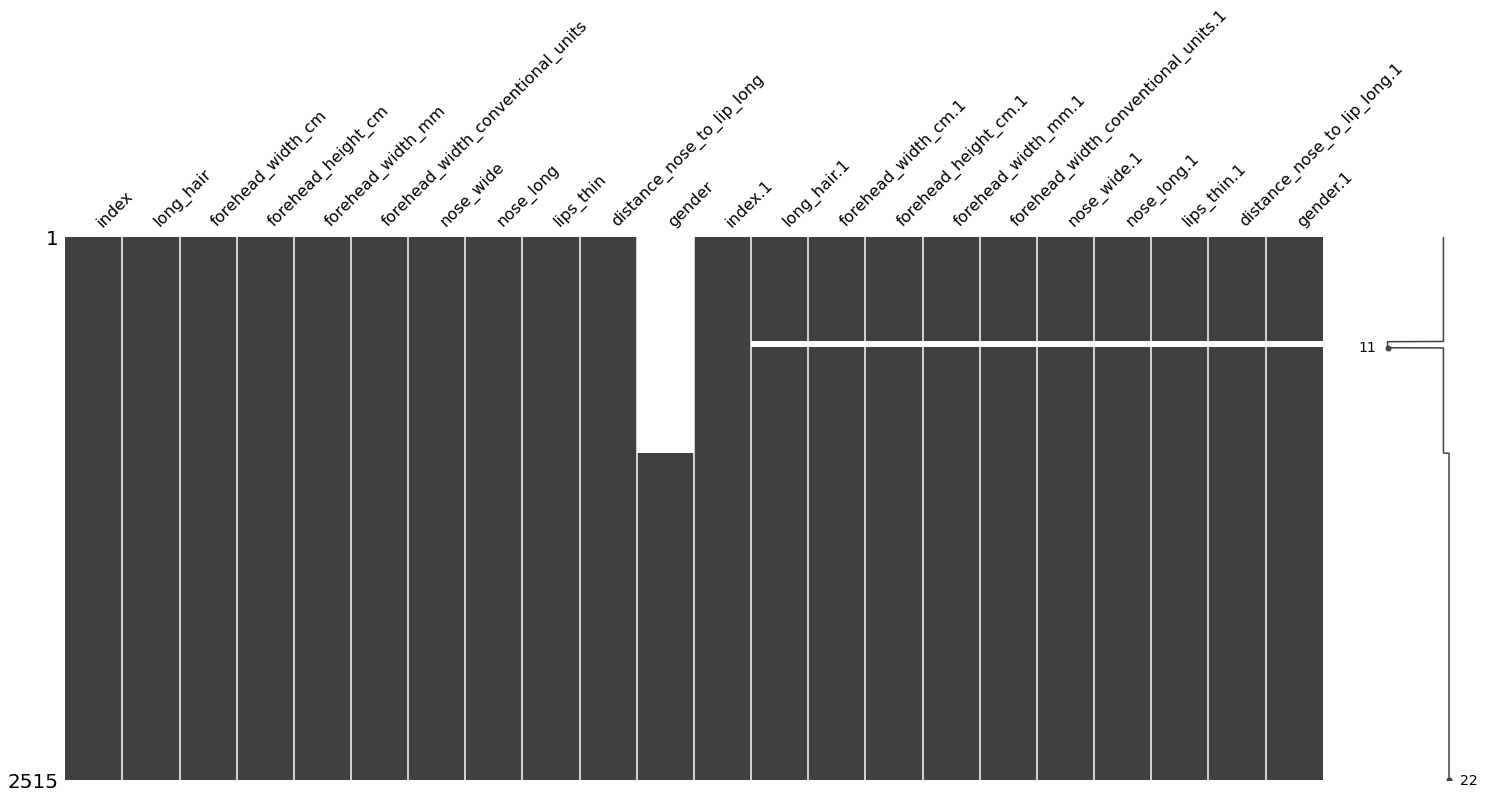

In [5]:
miss.matrix(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 0 to 2514
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                2515 non-null   int64  
 1   long_hair                            2515 non-null   float64
 2   forehead_width_cm                    2515 non-null   float64
 3   forehead_height_cm                   2515 non-null   float64
 4   forehead_width_mm                    2515 non-null   float64
 5   forehead_width_conventional_units    2515 non-null   float64
 6   nose_wide                            2515 non-null   float64
 7   nose_long                            2515 non-null   float64
 8   lips_thin                            2515 non-null   float64
 9   distance_nose_to_lip_long            2515 non-null   float64
 10  gender                               1514 non-null   object 
 11  index.1                       

Видим что таблицу как-будто склеили справа с такой же таблицей

In [7]:
df[['index', 'gender', 'index.1', 'gender.1']]

,index,gender,index.1,gender.1
0,0,NaN,2515,Female
1,1,NaN,2516,Male
2,2,NaN,2517,Male
3,3,NaN,2518,Male
4,4,NaN,2519,Male
...,...,...,...,...
2510,2510,Male,4996,Female
2511,2511,Male,4997,Female
2512,2512,Female,4998,Female
2513,2513,Male,4999,Female


### 1.2 Формирование отдельных таблиц и их дальнейшее объединение

### Таблица df1

In [8]:
# вычленим колоки без индекса '.1'
df1 = df.iloc[:,0:11]
df1

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN
1,1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN
2,2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN
3,3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN
4,4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2510,2510,0.915744,13.9,6.4,139.0,0.161290,0.604791,0.851645,0.766959,0.763820,Male
2511,2511,0.820041,13.8,5.1,138.0,0.154839,0.933549,0.537350,0.918460,0.938982,Male
2512,2512,0.659143,12.2,5.3,122.0,0.051613,0.531385,0.456792,0.489438,0.457138,Female
2513,2513,0.664928,12.1,5.2,121.0,0.045161,0.538634,0.610885,0.977585,0.942940,Male


In [9]:
df1.duplicated().sum()

0

### Таблица df2

In [10]:
# вычленим колоки дублирующие c индексом '.1'
df2 = df.iloc[:,11:]
df2.head()

,index.1,long_hair.1,forehead_width_cm.1,forehead_height_cm.1,forehead_width_mm.1,forehead_width_conventional_units.1,nose_wide.1,nose_long.1,lips_thin.1,distance_nose_to_lip_long.1,gender.1
0,2515,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,2516,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,2517,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,2518,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,2519,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


In [11]:
# проверим на пропуски так как первоначальный анализ показал их наличие
df2[df2['long_hair.1'].isna()]

,index.1,long_hair.1,forehead_width_cm.1,forehead_height_cm.1,forehead_width_mm.1,forehead_width_conventional_units.1,nose_wide.1,nose_long.1,lips_thin.1,distance_nose_to_lip_long.1,gender.1
485,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# удалим строки с NaN. Выберем при этом столбец long_hair.1 так как столбец index.1 не содержит NaN
df2.dropna(subset=['long_hair.1'], inplace=True)

In [13]:
def rename_col(columns):
    """Ф-ция убирает 2 последних символа в названиях колонок
    """
    return map(lambda x: x[:-2], columns)

In [14]:
# переименуем колонки
df2.columns = rename_col(df2.columns)
df2.head()

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,2515,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,2516,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,2517,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,2518,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,2519,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


### Объединение df1 и df2

In [15]:
# объединим колонки
df_concat = pd.concat([df1, df2])
df_concat

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN
1,1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN
2,2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN
3,3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN
4,4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2510,4996,0.645930,13.6,5.1,136.0,0.141935,0.443641,0.255464,0.116379,0.042459,Female
2511,4997,0.501251,11.9,5.4,119.0,0.032258,0.473038,0.469482,0.067636,0.210801,Female
2512,4998,0.701357,12.9,5.7,129.0,0.096774,0.388300,0.428321,0.322559,0.199743,Female
2513,4999,0.684078,13.2,6.2,132.0,0.116129,0.067981,0.167563,0.218222,0.370723,Female


### Установим колонку index в качестве индексов таблицы

In [16]:
# проверим на наличие дубликатов в индексах
df_concat['index'].duplicated().sum()

0

In [17]:
# дубликаты всей таблицы
df_concat.duplicated().sum()

0

In [18]:
df_concat.set_index('index', inplace = True)

In [19]:
df_concat.head()

,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
index,,,,,,,,,,
0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN
1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN
2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN
3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN
4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN


<AxesSubplot:>

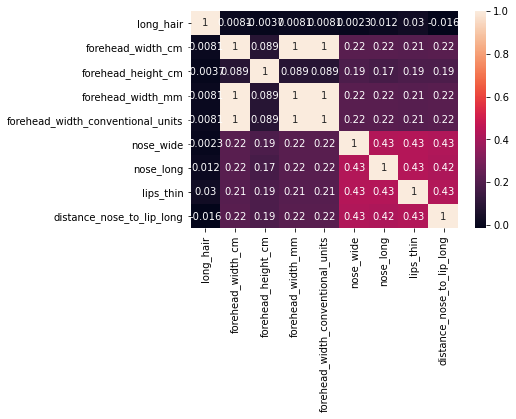

In [20]:
sns.heatmap(df_concat.corr(),annot=True)

## 2. Уменьшение влияние погрешности путем приравнивания значений диапазона [0,0.5) к 0, а [0.5, 1) —- к 1

### Создадим таблицу из колонок, которую надо преобразовать в 0 и 1

In [21]:
# колонки в которых нужно произвести бинаризацию
columns = ['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair']

In [22]:
df_bin = df_concat[columns]
df_bin

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair
index,,,,,
0,0.895614,0.477485,0.841261,0.902628,0.704275
1,0.202520,0.186825,0.719697,0.309122,0.118690
2,0.892793,0.723152,0.725821,0.720640,0.203894
3,0.024963,0.562005,0.831515,0.770379,0.386228
4,0.415389,0.063705,0.211584,0.157217,0.564020
...,...,...,...,...,...
4996,0.443641,0.255464,0.116379,0.042459,0.645930
4997,0.473038,0.469482,0.067636,0.210801,0.501251
4998,0.388300,0.428321,0.322559,0.199743,0.701357


### Сделаем разными способами бинаризацию

Приведем при этом к одному типу данных 'int32' для корректного дальнейшего сравнения результатов

**1 способ**

In [23]:
%%timeit
df_bin.where(df_bin >= 0.5, 0).where(df_bin < 0.5, 1)

2.81 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
a = df_bin.where(df_bin >= 0.5, 0).where(df_bin < 0.5, 1)
a

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair
index,,,,,
0,1.0,0.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
4996,0.0,0.0,0.0,0.0,1.0
4997,0.0,0.0,0.0,0.0,1.0
4998,0.0,0.0,0.0,0.0,1.0


In [25]:
a.dtypes

nose_wide                    float64
nose_long                    float64
lips_thin                    float64
distance_nose_to_lip_long    float64
long_hair                    float64
dtype: object

In [26]:
a = a.astype('int32')

In [27]:
a.dtypes

nose_wide                    int32
nose_long                    int32
lips_thin                    int32
distance_nose_to_lip_long    int32
long_hair                    int32
dtype: object

**2 способ**

[apply, map, applymap](https://kanoki.org/2019/11/25/pandas-apply-map-and-applymap/)

In [28]:
%%timeit
df_bin.applymap(lambda x: 0 if x < 0.5 else 1)

30.9 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
b = df_bin.applymap(lambda x: 0 if x < 0.5 else 1)
b

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair
index,,,,,
0,1,0,1,1,1
1,0,0,1,0,0
2,1,1,1,1,0
3,0,1,1,1,0
4,0,0,0,0,1
...,...,...,...,...,...
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


In [30]:
b.dtypes

nose_wide                    int64
nose_long                    int64
lips_thin                    int64
distance_nose_to_lip_long    int64
long_hair                    int64
dtype: object

In [31]:
b = b.astype('int32')

In [32]:
b.dtypes

nose_wide                    int32
nose_long                    int32
lips_thin                    int32
distance_nose_to_lip_long    int32
long_hair                    int32
dtype: object

**3 способ**

In [33]:
def interval(col):
    return np.where(col >= 0.5, 1, 0)

In [34]:
%%timeit
df_bin.apply(interval)

2.76 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
c = df_bin.apply(interval)
c

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair
index,,,,,
0,1,0,1,1,1
1,0,0,1,0,0
2,1,1,1,1,0
3,0,1,1,1,0
4,0,0,0,0,1
...,...,...,...,...,...
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


In [36]:
c.dtypes

nose_wide                    int32
nose_long                    int32
lips_thin                    int32
distance_nose_to_lip_long    int32
long_hair                    int32
dtype: object

### Проверка на равенсто полученных таблиц разными способами

In [37]:
a.equals(b)

True

In [38]:
b.equals(c)

True

In [39]:
a.equals(c)

True

## 3. Оставить один из дублирующих друг друга столбцов.

<AxesSubplot:>

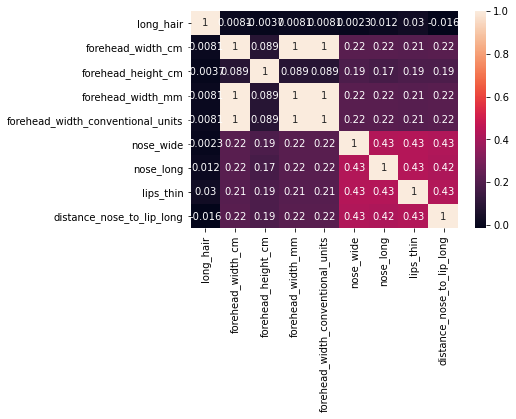

In [40]:
sns.heatmap(df_concat.corr(),annot=True)

`forehead_width_mm` и	`forehead_width_conventional_units` - удалим. Они повторяют смысловю интерпретацию `orehead_width_cm`

### Создадим итоговую таблицу

In [41]:
df_new = pd.concat([c, df_concat[['forehead_width_cm', 'forehead_height_cm', 'gender']]], axis=1)
df_new

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm,gender
index,,,,,,,,
0,1,0,1,1,1,11.8,6.1,NaN
1,0,0,1,0,0,14.0,5.4,NaN
2,1,1,1,1,0,11.8,6.3,NaN
3,0,1,1,1,0,14.4,6.1,NaN
4,0,0,0,0,1,13.5,5.9,NaN
...,...,...,...,...,...,...,...,...
4996,0,0,0,0,1,13.6,5.1,Female
4997,0,0,0,0,1,11.9,5.4,Female
4998,0,0,0,0,1,12.9,5.7,Female


<AxesSubplot:>

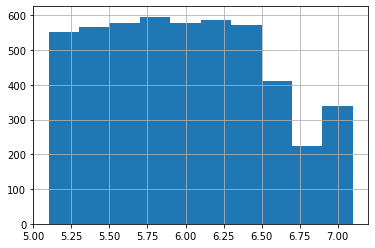

In [42]:
df_new['forehead_height_cm'].hist()

### Стандартизация признаков

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()

In [45]:
df_new[['forehead_width_cm', 'forehead_height_cm']] = scaler.fit_transform(
                                            df_new[['forehead_width_cm', 'forehead_height_cm']])

In [46]:
df_new.head()

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm,gender
index,,,,,,,,
0,1,0,1,1,1,-1.247933,0.283971,NaN
1,0,0,1,0,0,0.739389,-1.009418,NaN
2,1,1,1,1,0,-1.247933,0.653511,NaN
3,0,1,1,1,0,1.100720,0.283971,NaN
4,0,0,0,0,1,0.287725,-0.085568,NaN


## 4. Моделирование

### 4.1 Разбиение на обучающую и предсказательную части

### Предсказательный набор данных

In [47]:
df_predict = df_new[df_new['gender'].isna()]
df_predict

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm,gender
index,,,,,,,,
0,1,0,1,1,1,-1.247933,0.283971,NaN
1,0,0,1,0,0,0.739389,-1.009418,NaN
2,1,1,1,1,0,-1.247933,0.653511,NaN
3,0,1,1,1,0,1.100720,0.283971,NaN
4,0,0,0,0,1,0.287725,-0.085568,NaN
...,...,...,...,...,...,...,...,...
996,0,0,0,1,0,-0.434938,0.099202,NaN
997,0,0,0,0,1,0.829721,-1.194188,NaN
998,1,1,1,0,1,-0.976935,0.468741,NaN


In [48]:
df_predict[df_predict['gender'].isna()].duplicated().value_counts()

False    883
True     118
dtype: int64

Присутсвуют дубликаты, но эти примеры надо предсказать, на обучение они не повлияют

In [49]:
x_predict = df_predict.drop('gender', axis=1)
x_predict

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm
index,,,,,,,
0,1,0,1,1,1,-1.247933,0.283971
1,0,0,1,0,0,0.739389,-1.009418
2,1,1,1,1,0,-1.247933,0.653511
3,0,1,1,1,0,1.100720,0.283971
4,0,0,0,0,1,0.287725,-0.085568
...,...,...,...,...,...,...,...
996,0,0,0,1,0,-0.434938,0.099202
997,0,0,0,0,1,0.829721,-1.194188
998,1,1,1,0,1,-0.976935,0.468741


### Обучающий набор данных

In [50]:
df_train = df_new[~df_new['gender'].isna()]
df_train

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm,gender
index,,,,,,,,
1001,1,1,1,1,1,0.197392,0.283971,Male
1002,1,1,1,1,0,0.287725,0.838281,Male
1003,1,0,0,0,1,0.197392,-1.009418,Female
1004,0,0,0,0,1,0.829721,0.653511,Female
1005,0,0,0,0,1,-0.615603,-1.378958,Female
...,...,...,...,...,...,...,...,...
4996,0,0,0,0,1,0.378057,-1.563727,Female
4997,0,0,0,0,1,-1.157600,-1.009418,Female
4998,0,0,0,0,1,-0.254272,-0.455108,Female


In [51]:
df_train.duplicated().sum()

1256

Имеются дубликты!!!!

Удалим дубли

In [52]:
df_train.drop_duplicates(inplace=True)

In [53]:
df_train.duplicated().sum()

0

In [54]:
X = df_train.drop('gender', axis=1)
X.head()

,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,long_hair,forehead_width_cm,forehead_height_cm
index,,,,,,,
1001,1,1,1,1,1,0.197392,0.283971
1002,1,1,1,1,0,0.287725,0.838281
1003,1,0,0,0,1,0.197392,-1.009418
1004,0,0,0,0,1,0.829721,0.653511
1005,0,0,0,0,1,-0.615603,-1.378958


In [55]:
y = df_train['gender']
y

index
1001      Male
1002      Male
1003    Female
1004    Female
1005    Female
         ...  
4986      Male
4990    Female
4992      Male
4993    Female
4995      Male
Name: gender, Length: 2744, dtype: object

### Факторизация

In [56]:
y = y.map({'Male': 1, 'Female': 0})
y

index
1001    1
1002    1
1003    0
1004    0
1005    0
       ..
4986    1
4990    0
4992    1
4993    0
4995    1
Name: gender, Length: 2744, dtype: int64

### 4.2 Машинное обучение

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### RandomForestClassifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [60]:
rfc = RandomForestClassifier(random_state=42)

In [61]:
parameters = {'n_estimators': [25, 50, 100, 150, 200],
             'max_depth': [3, 5, 7, 9, 11],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 3, 4]}

In [62]:
clf = GridSearchCV(rfc, parameters, cv=5)

In [63]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [25, 50, 100, 150, 200]})

In [64]:
best_rfc = clf.best_estimator_

In [65]:
clf.best_score_

0.9755212652529319

In [66]:
clf.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

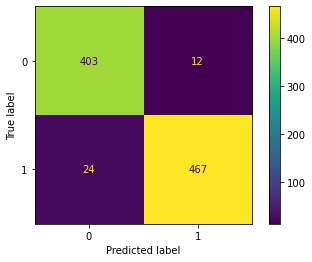

In [67]:
plot_confusion_matrix(clf, X_test, y_test)

In [68]:
ans = best_rfc.predict(x_predict)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [69]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res_rfc.csv', header=False, index=False)

Прошел

Попытка обучить на всей выборке

In [70]:
clf2 = GridSearchCV(rfc, parameters, cv=5)

In [71]:
clf2.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [25, 50, 100, 150, 200]})

In [72]:
best_rfc = clf2.best_estimator_

In [73]:
clf2.best_score_

0.9693876058660071

In [74]:
clf2.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [75]:
ans = best_rfc.predict(x_predict)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [76]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res_rfc2.csv', header=False, index=False)

Прошел

### LogisticRegression

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
Logres = LogisticRegression(random_state=42)

In [79]:
Logres.fit(X, y)

LogisticRegression(random_state=42)

In [80]:
ans = Logres.predict(x_predict)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [81]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res_logreg.csv', header=False, index=False)

Прошел

### KNeighborsClassifier

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [84]:
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [85]:
ans = neigh.predict(x_predict)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [86]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res_KNeighbors.csv', header=False, index=False)

Прошел

### Метод опорных векторов

In [87]:
from sklearn.svm import SVC

In [88]:
svc_clf = SVC()

In [89]:
svc_clf.fit(X, y)

SVC()

In [90]:
ans = svc_clf.predict(x_predict)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [91]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res_svc.csv', header=False, index=False)

Прошел метод

## Нейросеть tensorflow

In [92]:
import tensorflow as tf

In [93]:
def get_basic_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(7,)), # input shape required
      tf.keras.layers.Dense(10, activation=tf.nn.relu),
      tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [94]:
BATCH_SIZE = 30

model = get_basic_model()
model.fit(X, y, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
92/92 [==============================] - 0s 2ms/step - loss: 0.5938 - accuracy: 0.6571
Epoch 2/15
92/92 [==============================] - 0s 920us/step - loss: 0.3898 - accuracy: 0.8659
Epoch 3/15
92/92 [==============================] - 0s 920us/step - loss: 0.2516 - accuracy: 0.9158
Epoch 4/15
92/92 [==============================] - 0s 1ms/step - loss: 0.1790 - accuracy: 0.9362
Epoch 5/15
92/92 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9472
Epoch 6/15
92/92 [==============================] - 0s 1ms/step - loss: 0.1295 - accuracy: 0.9504
Epoch 7/15
92/92 [==============================] - 0s 920us/step - loss: 0.1214 - accuracy: 0.9534
Epoch 8/15
92/92 [==============================] - 0s 920us/step - loss: 0.1159 - accuracy: 0.9534
Epoch 9/15
92/92 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.9548
Epoch 10/15
92/92 [==============================] - 0s 1ms/step - loss: 0.1103 - accuracy: 0.9570
Epoch 11/15

In [95]:
ans = model.predict(x_predict).argmax(axis=1)
ans

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [96]:
pd.Series(np.where(ans==1, "Male", "Female")).to_csv('res.csv', header=False, index=False)

Этот способ прошел